This script assumes your files are already crop to wider area of study, here it is Western Paraguay.
This script processes a set of raster files representing various geographical and environmental features, including land-use categories and tree cover data. The primary objective is to generate feature and deforestation raster files that align with the given land-use category raster files. The script executes the following steps:

1. Import Libraries and Set Constants: The script begins by importing necessary libraries such as rasterio, numpy, pandas, and matplotlib. It also sets up the required paths and constants, including the server path, output path, and various raster file paths.

2. Define Crop and Mask Function: The crop_and_mask_raster function is defined, which takes the paths of the source raster, property raster, output raster, and the maximum height and width as inputs. This function performs several operations:

* Reads the source and property rasters.
* Pads both the source data and property data to the maximum dimensions.
* Creates a mask using the property raster, where zero values are considered as no data.
* Applies the mask to the source raster, replacing no data values with a specified no data value.
* Saves the masked raster with updated metadata, including height, width, no data value, and data type.

3. Determine Maximum Dimensions: The script determines the maximum dimensions of all rasters by comparing the heights and widths of the tree cover, deforestation, and mask rasters.

4. Process Raster Files: The script processes the raster files by calling the crop_and_mask_raster function with the appropriate parameters. This includes the file paths for the source raster, property raster (mask), output raster, and the maximum height and width.

The output of this script is a set of masked raster files for each feature and the target variable (deforestation). These files are cropped and masked based on the land-use plans, ensuring that the data aligns with the geographical area of interest.



# Import Libraries

In [1]:
import os
import sys
import rasterio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shutil
from pathlib import Path
from rasterio.mask import mask
from rasterio.enums import Resampling
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.plot import show



# Import Constants

In [2]:
# Get the current working directory
current_dir = os.path.abspath('')

# Search for the 'constants.py' file starting from the current directory and moving up the hierarchy
project_root = current_dir
while not os.path.isfile(os.path.join(project_root, 'constants.py')):
    project_root = os.path.dirname(project_root)

# Add the project root to the Python path
sys.path.append(project_root)


In [3]:
from constants import (SERVER_PATH,
 OUTPUT_PATH,
  LUP_LUT_RASTER,
   DEFORESTATION_1120_PATH,
    TREECOVER_2010, SOIL_RASTER, 
    ROAD_DISTANCE_RASTER,
     RIVER_DISTANCE_RASTER,
     PRECIPITATION_FILEPATH,
     SIM_LUP_RASTER_PATH,
     PORTS_FILEPATH,
     CITIES_FILEPATH
)


In [7]:
raster_to_use_as_mask

'/Users/romero61/../../capstone/pyforest/ml_data/output/processed_rasters/land_type/optimal_lup_25_land_type_raster.tif'

In [15]:
# Constants
raster_to_use_as_mask25 = os.path.join(SIM_LUP_RASTER_PATH[0], 'optimal_lup_25_land_type_raster.tif')

raster_to_use_as_mask50 = os.path.join(SIM_LUP_RASTER_PATH[0], 'optimal_lup_50_land_type_raster.tif')

raster_to_use_as_mask5 = os.path.join(SIM_LUP_RASTER_PATH[0], 'optimal_lup_5_land_type_raster.tif')

raster_to_use_as_maskhedges = os.path.join(SIM_LUP_RASTER_PATH[0], 'optimal_lup_hedges_land_type_raster.tif')


In [ ]:

# new output directory
output_folder = os.path.join(SERVER_PATH, 'ml_data', 'output', 'masked_rasters_sims')
os.makedirs(output_folder, exist_ok=True)

In [14]:
def crop_and_mask_raster(src_raster_path, property_raster_path, output_raster_path, max_height, max_width):
    with rasterio.open(src_raster_path) as src:
        # Read the source raster
        src_data = src.read(1)
        
        with rasterio.open(property_raster_path) as property_raster:
            # Read the property limits raster
            property_data = property_raster.read(1)

            # Pad both the source data and property data to the maximum dimensions
            src_data = np.pad(src_data, ((0, max_height - src_data.shape[0]), (0, max_width - src_data.shape[1])), constant_values=0)
            property_data = np.pad(property_data, ((0, max_height - property_data.shape[0]), (0, max_width - property_data.shape[1])), constant_values=0)

            # Create a mask using the padded property limits raster, where zero values are considered as nodata
            mask_data = (property_data != 0)

            # Check if the nodata value is set for the source raster, otherwise use a default value
            nodata_value = src.nodata if src.nodata is not None else -1

            # Apply the mask to the source raster
            src_data_masked = np.where(mask_data, src_data, nodata_value)
            print(f"Source data shape:{src_data.shape} Property data shape:{property_data.shape} Mask data shape:, {mask_data.shape} After masking: Source data masked shape:, {src_data_masked.shape}")

             # Save the masked raster
            profile = src.profile
            profile['height'] = max_height
            profile['width'] = max_width
            profile['nodata'] = nodata_value
            profile['dtype'] = 'int16'
            with rasterio.open(output_raster_path, 'w', **profile) as dst:
                dst.write(src_data_masked.astype(profile['dtype']), 1)



In [9]:
# Dimensions
max_height, max_width = 0, 0
with rasterio.open(TREECOVER_2010) as tree_cover_src:
     with rasterio.open(DEFORESTATION_1120_PATH) as deforestation_src, rasterio.open(raster_to_use_as_mask) as mask_src:
        # Determine the maximum dimensions of all rasters
        max_height = max(max_height, mask_src.height, tree_cover_src.height, deforestation_src.height)
        max_width = max(max_width, mask_src.width, tree_cover_src.width, deforestation_src.width)
        print(max_height)
        print(max_width)




22512
20381


In [10]:
with rasterio.open(TREECOVER_2010) as tree_cover_src:
    profile = tree_cover_src.profile
    profile.update(nodata=-1, dtype='int16')

profile

{'driver': 'GTiff', 'dtype': 'int16', 'nodata': -1, 'width': 20381, 'height': 22512, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.00026949458523585647, 0.0, -62.64186038139295,
       0.0, -0.00026949458523585647, -19.287457970745013), 'tiled': False, 'interleave': 'band'}

# Process Files

## Intital Stack

## Soil

<Axes: >

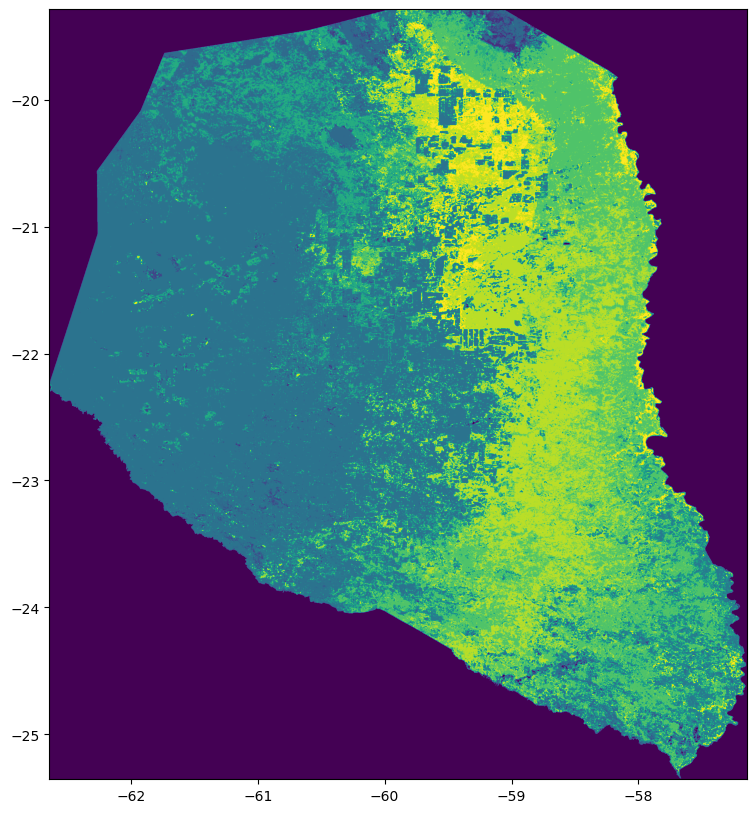

In [14]:
from rasterio.plot import show

# Open example raster
raster = rasterio.open(SOIL_RASTER)

# Plot raster
fig, ax = plt.subplots(1, figsize = (10, 10))
show(raster, ax = ax)
plt.gca()

In [17]:
'''
# Open the reference raster
with rasterio.open(TREECOVER_2010) as ref_raster:
    ref_transform = ref_raster.transform
    ref_crs = ref_raster.crs
    ref_width = ref_raster.width
    ref_height = ref_raster.height

    # Open the raster to be resampled
    with rasterio.open(SOIL_RASTER) as soil_raster:
        soil_data = soil_raster.read(1)

        # Create a new array for the resampled data
        resampled_data = np.empty(shape=(ref_height, ref_width))

        # Resample the soil data
        reproject(
            source=soil_data,
            destination=resampled_data,
            src_transform=soil_raster.transform,
            src_crs=soil_raster.crs,
            dst_transform=ref_transform,
            dst_crs=ref_crs,
            resampling=Resampling.nearest)

        # Write the resampled data to a new raster file
        with rasterio.open('resampled_soil.tif', 'w', driver='GTiff',
                           height=ref_height, width=ref_width,
                           count=1, dtype=str(soil_data.dtype),
                           crs=ref_crs, transform=ref_transform) as dst:
            dst.write(resampled_data, 1)
'''


Source data shape:(22512, 20381) Property data shape:(22512, 20381) Mask data shape:, (22512, 20381) After masking: Source data masked shape:, (22512, 20381)


In [19]:
soil_masked_output_raster25 = os.path.join(output_folder,'soil_masked25.tif')
#pass the resampled soil data to your crop_and_mask_raster function
crop_and_mask_raster('/Users/romero61/github/PYFOREST-ML/03-preprocessing/resampled_soil.tif', raster_to_use_as_mask25, soil_masked_output_raster25, max_height, max_width)

soil_masked_output_raster50 = os.path.join(output_folder,'soil_masked50.tif')
#pass the resampled soil data to your crop_and_mask_raster function
crop_and_mask_raster('/Users/romero61/github/PYFOREST-ML/03-preprocessing/resampled_soil.tif', raster_to_use_as_mask50, soil_masked_output_raster50, max_height, max_width)

soil_masked_output_raster5 = os.path.join(output_folder,'soil_masked5.tif')
#pass the resampled soil data to your crop_and_mask_raster function
crop_and_mask_raster('/Users/romero61/github/PYFOREST-ML/03-preprocessing/resampled_soil.tif', raster_to_use_as_mask5, soil_masked_output_raster5, max_height, max_width)

soil_masked_output_rasterhedges = os.path.join(output_folder,'soil_maskedhedges.tif')
#pass the resampled soil data to your crop_and_mask_raster function
crop_and_mask_raster('/Users/romero61/github/PYFOREST-ML/03-preprocessing/resampled_soil.tif', raster_to_use_as_maskhedges, soil_masked_output_rasterhedges, max_height, max_width)

Source data shape:(22512, 20381) Property data shape:(22512, 20381) Mask data shape:, (22512, 20381) After masking: Source data masked shape:, (22512, 20381)
Source data shape:(22512, 20381) Property data shape:(22512, 20381) Mask data shape:, (22512, 20381) After masking: Source data masked shape:, (22512, 20381)
Source data shape:(22512, 20381) Property data shape:(22512, 20381) Mask data shape:, (22512, 20381) After masking: Source data masked shape:, (22512, 20381)
Source data shape:(22512, 20381) Property data shape:(22512, 20381) Mask data shape:, (22512, 20381) After masking: Source data masked shape:, (22512, 20381)


# Precipitation

In [22]:
# Process PRECIPITATION_FILEPATH
precipitation_masked_output_raster25 = os.path.join(output_folder,'precipitation_masked25.tif')
#pass the resampled precipitation data to your crop_and_mask_raster function
crop_and_mask_raster(PRECIPITATION_FILEPATH, raster_to_use_as_mask25, precipitation_masked_output_raster25, max_height, max_width)

precipitation_masked_output_raster50 = os.path.join(output_folder,'precipitation_masked50.tif')
#pass the resampled precipitation data to your crop_and_mask_raster function
crop_and_mask_raster(PRECIPITATION_FILEPATH, raster_to_use_as_mask50, precipitation_masked_output_raster50, max_height, max_width)

precipitation_masked_output_raster5 = os.path.join(output_folder,'precipitation_masked5.tif')
#pass the resampled precipitation data to your crop_and_mask_raster function
crop_and_mask_raster(PRECIPITATION_FILEPATH, raster_to_use_as_mask5, precipitation_masked_output_raster5, max_height, max_width)

precipitation_masked_output_rasterhedges = os.path.join(output_folder,'precipitation_maskedhedges.tif')
#pass the resampled precipitation data to your crop_and_mask_raster function
crop_and_mask_raster(PRECIPITATION_FILEPATH, raster_to_use_as_maskhedges, precipitation_masked_output_rasterhedges, max_height, max_width)


Source data shape:(22512, 20381) Property data shape:(22512, 20381) Mask data shape:, (22512, 20381) After masking: Source data masked shape:, (22512, 20381)
Source data shape:(22512, 20381) Property data shape:(22512, 20381) Mask data shape:, (22512, 20381) After masking: Source data masked shape:, (22512, 20381)
Source data shape:(22512, 20381) Property data shape:(22512, 20381) Mask data shape:, (22512, 20381) After masking: Source data masked shape:, (22512, 20381)
Source data shape:(22512, 20381) Property data shape:(22512, 20381) Mask data shape:, (22512, 20381) After masking: Source data masked shape:, (22512, 20381)


# Distance to Cities and Ports

In [31]:
'''# Open the reference raster
with rasterio.open(TREECOVER_2010) as ref_raster:
    ref_transform = ref_raster.transform
    ref_crs = ref_raster.crs
    ref_width = ref_raster.width
    ref_height = ref_raster.height

    # Open the raster to be resampled
    with rasterio.open(PORTS_FILEPATH) as ports_src:
        ports_data = ports_src.read(1)
        ports_profile = ports_src.profile

        # Update the profile of the resampled raster
        ports_profile.update({
            'crs': ref_crs,
            'transform': ref_transform,  # Use the transform of the reference raster
            'width': ref_width,  # Use the width of the reference raster
            'height': ref_height,  # Use the height of the reference raster
            'nodata': -1,
            'dtype': 'int16'
        })

        # Create a new array for the resampled data
        resampled_data = np.empty((ref_height, ref_width))

        # Resample the ports data
        reproject(
            source=ports_data,
            destination=resampled_data,
            src_transform=ports_src.transform,
            src_crs=ports_src.crs,
            dst_transform=ref_transform,  # Use the transform of the reference raster
            dst_crs=ref_crs,
            resampling=Resampling.nearest)

        # Write the resampled data to a new raster file
        with rasterio.open('resampled_ports.tif', 'w', **ports_profile) as dst:
            dst.write(resampled_data.astype('int16'), 1)

ports_masked_output_raster = os.path.join(output_folder,'ports_masked.tif')

# Pass the resampled ports data to your crop_and_mask_raster function
crop_and_mask_raster('resampled_ports.tif', raster_to_use_as_mask, ports_masked_output_raster, max_height, max_width)'''


Source data shape:(22512, 20381) Property data shape:(22512, 20381) Mask data shape:, (22512, 20381) After masking: Source data masked shape:, (22512, 20381)


In [24]:
# Process "/Users/romero61/github/PYFOREST-ML/03-preprocessing/resampled_ports.tif"
ports_masked_output_raster25 = os.path.join(output_folder,'ports_masked25.tif')
#pass the resampled ports data to your crop_and_mask_raster function
crop_and_mask_raster("/Users/romero61/github/PYFOREST-ML/03-preprocessing/resampled_ports.tif", raster_to_use_as_mask25, ports_masked_output_raster25, max_height, max_width)

ports_masked_output_raster50 = os.path.join(output_folder,'ports_masked50.tif')
#pass the resampled ports data to your crop_and_mask_raster function
crop_and_mask_raster("/Users/romero61/github/PYFOREST-ML/03-preprocessing/resampled_ports.tif", raster_to_use_as_mask50, ports_masked_output_raster50, max_height, max_width)

ports_masked_output_raster5 = os.path.join(output_folder,'ports_masked5.tif')
#pass the resampled ports data to your crop_and_mask_raster function
crop_and_mask_raster("/Users/romero61/github/PYFOREST-ML/03-preprocessing/resampled_ports.tif", raster_to_use_as_mask5, ports_masked_output_raster5, max_height, max_width)

ports_masked_output_rasterhedges = os.path.join(output_folder,'ports_maskedhedges.tif')
#pass the resampled ports data to your crop_and_mask_raster function
crop_and_mask_raster("/Users/romero61/github/PYFOREST-ML/03-preprocessing/resampled_ports.tif", raster_to_use_as_maskhedges, ports_masked_output_rasterhedges, max_height, max_width)

Source data shape:(22512, 20381) Property data shape:(22512, 20381) Mask data shape:, (22512, 20381) After masking: Source data masked shape:, (22512, 20381)
Source data shape:(22512, 20381) Property data shape:(22512, 20381) Mask data shape:, (22512, 20381) After masking: Source data masked shape:, (22512, 20381)
Source data shape:(22512, 20381) Property data shape:(22512, 20381) Mask data shape:, (22512, 20381) After masking: Source data masked shape:, (22512, 20381)
Source data shape:(22512, 20381) Property data shape:(22512, 20381) Mask data shape:, (22512, 20381) After masking: Source data masked shape:, (22512, 20381)


In [32]:
'''# Open the reference raster
with rasterio.open(TREECOVER_2010) as ref_raster:
    ref_transform = ref_raster.transform
    ref_crs = ref_raster.crs
    ref_width = ref_raster.width
    ref_height = ref_raster.height

    # Open the raster to be resampled
    with rasterio.open(CITIES_FILEPATH) as cities_src:
        cities_data = cities_src.read(1)
        cities_profile = cities_src.profile

        # Update the profile of the resampled raster
        cities_profile.update({
            'crs': ref_crs,
            'transform': ref_transform,  # Use the transform of the reference raster
            'width': ref_width,  # Use the width of the reference raster
            'height': ref_height,  # Use the height of the reference raster
            'nodata': -1,
            'dtype': 'int16'
        })

        # Create a new array for the resampled data
        resampled_data = np.empty((ref_height, ref_width))

        # Resample the cities data
        reproject(
            source=cities_data,
            destination=resampled_data,
            src_transform=cities_src.transform,
            src_crs=cities_src.crs,
            dst_transform=ref_transform,  # Use the transform of the reference raster
            dst_crs=ref_crs,
            resampling=Resampling.nearest)

        # Write the resampled data to a new raster file
        with rasterio.open('resampled_cities.tif', 'w', **cities_profile) as dst:
            dst.write(resampled_data.astype('int16'), 1)

cities_masked_output_raster = os.path.join(output_folder,'cities_masked.tif')

# Pass the resampled cities data to your crop_and_mask_raster function
crop_and_mask_raster('resampled_cities.tif', raster_to_use_as_mask, cities_masked_output_raster, max_height, max_width)'''

Source data shape:(22512, 20381) Property data shape:(22512, 20381) Mask data shape:, (22512, 20381) After masking: Source data masked shape:, (22512, 20381)


In [25]:
# Process "/Users/romero61/github/PYFOREST-ML/03-preprocessing/resampled_cities.tif"
cities_masked_output_raster25 = os.path.join(output_folder,'cities_masked25.tif')
#pass the resampled cities data to your crop_and_mask_raster function
crop_and_mask_raster("/Users/romero61/github/PYFOREST-ML/03-preprocessing/resampled_cities.tif", raster_to_use_as_mask25, cities_masked_output_raster25, max_height, max_width)

cities_masked_output_raster50 = os.path.join(output_folder,'cities_masked50.tif')
#pass the resampled cities data to your crop_and_mask_raster function
crop_and_mask_raster("/Users/romero61/github/PYFOREST-ML/03-preprocessing/resampled_cities.tif", raster_to_use_as_mask50, cities_masked_output_raster50, max_height, max_width)

cities_masked_output_raster5 = os.path.join(output_folder,'cities_masked5.tif')
#pass the resampled cities data to your crop_and_mask_raster function
crop_and_mask_raster("/Users/romero61/github/PYFOREST-ML/03-preprocessing/resampled_cities.tif", raster_to_use_as_mask5, cities_masked_output_raster5, max_height, max_width)

cities_masked_output_rasterhedges = os.path.join(output_folder,'cities_maskedhedges.tif')
#pass the resampled cities data to your crop_and_mask_raster function
crop_and_mask_raster("/Users/romero61/github/PYFOREST-ML/03-preprocessing/resampled_cities.tif", raster_to_use_as_maskhedges, cities_masked_output_rasterhedges, max_height, max_width)

Source data shape:(22512, 20381) Property data shape:(22512, 20381) Mask data shape:, (22512, 20381) After masking: Source data masked shape:, (22512, 20381)
Source data shape:(22512, 20381) Property data shape:(22512, 20381) Mask data shape:, (22512, 20381) After masking: Source data masked shape:, (22512, 20381)
Source data shape:(22512, 20381) Property data shape:(22512, 20381) Mask data shape:, (22512, 20381) After masking: Source data masked shape:, (22512, 20381)
Source data shape:(22512, 20381) Property data shape:(22512, 20381) Mask data shape:, (22512, 20381) After masking: Source data masked shape:, (22512, 20381)


# Mask Simulated Land Use Plan
Here we only want to change pixels that are equal to zero to nodata value of -1

In [13]:
# Where files will save, can add subfolders if desired
output_dir = os.path.join(OUTPUT_PATH[0], 'sim_lup_features')
os.makedirs(output_dir, exist_ok=True)

## 25%

In [10]:
lup_25_raster = os.path.join(SIM_LUP_RASTER_PATH[0], 'optimal_lup_25_land_type_raster.tif')
lup_25_raster

'/Users/romero61/../../capstone/pyforest/ml_data/output/processed_rasters/land_type/optimal_lup_25_land_type_raster.tif'

<Axes: >

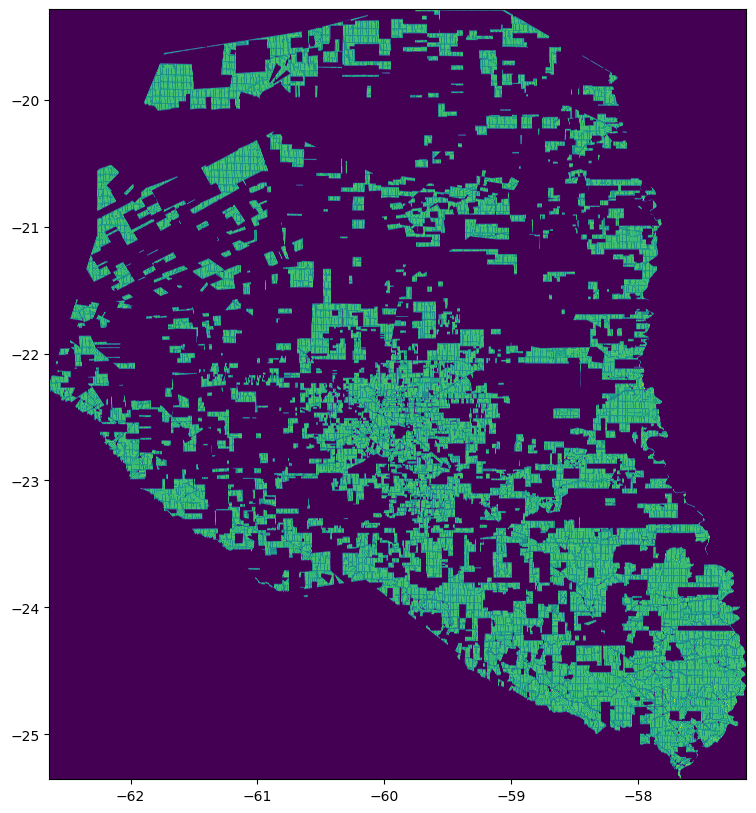

In [11]:
lup_raster = rasterio.open(lup_25_raster)
# Read the raster data into a NumPy array
lup_raster_array = lup_raster.read(1)
# Plot raster
fig, ax = plt.subplots(1, figsize = (10, 10))
show(lup_raster, ax = ax)
plt.gca()

In [12]:
# Create a mask where True represents zero values
zero_mask = lup_raster_array == 0

# For zero pixels, set the value to a nodata value
lup_raster_array[zero_mask] = -1

In [ ]:
with rasterio.open(TREECOVER_2010) as tree_cover_src:
    profile = tree_cover_src.profile
    profile.update(nodata=-1, dtype='int16')

profile

In [14]:
output_filepath = os.path.join(output_dir, 'sim25_raster.tif')
# Write the rasterized data to a new GeoTIFF file
with rasterio.open(output_filepath, 'w', **profile) as dst:
    dst.write(lup_raster_array.astype('int16'), 1)

## 50%

In [12]:
lup_50_raster = os.path.join(SIM_LUP_RASTER_PATH[0], 'optimal_lup_50_land_type_raster.tif')
lup_raster = rasterio.open(lup_50_raster)
# Read the raster data into a NumPy array
lup_raster_array = lup_raster.read(1)
# Create a mask where True represents zero values
zero_mask = lup_raster_array == 0

# For zero pixels, set the value to a nodata value
lup_raster_array[zero_mask] = -1

In [14]:
output_filepath = os.path.join(output_dir, 'sim50_raster.tif')
# Write the rasterized data to a new GeoTIFF file
with rasterio.open(output_filepath, 'w', **profile) as dst:
    dst.write(lup_raster_array.astype('int16'), 1)

## 5%

In [15]:
lup_5_raster = os.path.join(SIM_LUP_RASTER_PATH[0], 'optimal_lup_5_land_type_raster.tif')
lup_raster = rasterio.open(lup_5_raster)
# Read the raster data into a NumPy array
lup_raster_array = lup_raster.read(1)
# Create a mask where True represents zero values
zero_mask = lup_raster_array == 0

# For zero pixels, set the value to a nodata value
lup_raster_array[zero_mask] = -1

In [16]:
output_filepath = os.path.join(output_dir, 'sim5_raster.tif')
# Write the rasterized data to a new GeoTIFF file
with rasterio.open(output_filepath, 'w', **profile) as dst:
    dst.write(lup_raster_array.astype('int16'), 1)

## Hedges

In [17]:
lup_hedges_raster = os.path.join(SIM_LUP_RASTER_PATH[0], 'optimal_lup_hedges_land_type_raster.tif')
lup_raster = rasterio.open(lup_hedges_raster)
# Read the raster data into a NumPy array
lup_raster_array = lup_raster.read(1)
# Create a mask where True represents zero values
zero_mask = lup_raster_array == 0

# For zero pixels, set the value to a nodata value
lup_raster_array[zero_mask] = -1

In [ ]:
output_filepath = os.path.join(output_dir, 'simhedges_raster.tif')
# Write the rasterized data to a new GeoTIFF file
with rasterio.open(output_filepath, 'w', **profile) as dst:
    dst.write(lup_raster_array.astype('int16'), 1)